# 1. Code to generate Pseudo Random Numbers

In [1]:
# Load the libraries needed
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import time
import pandas as pd
import re

## 1.1. The logistic map

In [12]:
# Define a function for the logistic map
def f(x,r):
    return r*x*(1.0-x)

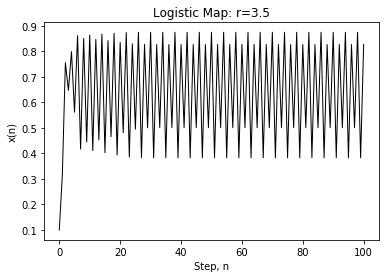

In [13]:
# Run and plot the logistic map
tmax = 101
t = range(0,tmax)
r = 3.5
x = np.zeros(tmax)
x[0] = 0.1
for i in range(1,tmax):
    x[i] = f(x[i-1],r)
plt.plot(t, x, '-', linewidth=1,color='black')
plt.title('Logistic Map: r=' + str(r))
plt.xlabel('Step, n')
plt.ylabel('x(n)')
plt.show()

## 1.2. The system clock

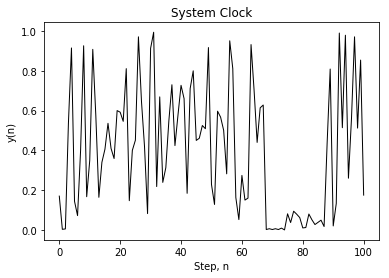

In [19]:
# Run an algorithm for use of the system clock
y = np.zeros(tmax)                                  #makes an array of 101 zeros in float numbers
for i in range(0,tmax):
    dt = datetime.now()                             #returns the current local date and time
    s = str(dt.microsecond)                         #takes the microseconds from the current time and makes in into a string. Why string and then float?
    y[i] = float(s[3:6])/1e3                        #populating the array y with floats from the current times microseconds divided by 1000
    time.sleep(float(s[0:3])/1e5)                   # time.sleep is the number of seconds the Python program should pause execution. Should be either an int or a float. Divided by 100000
plt.plot(t, y, '-', linewidth=1,color='black')      # plots y on the vertical axis and t on the hosizontal axis
plt.title('System Clock')
plt.xlabel('Step, n')
plt.ylabel('y(n)')
plt.show()

# 2. Estimation of pi

In [20]:
m = 40 #Blocks of estimates taken
n = int(1e3) #Size of each estimate

In [21]:
#Generate a set of m estimates of the area of a unit-radius quarter-circle
np.random.seed(42) #Seed the random number generator
A = np.zeros(m) #Set of circle area estimates
for i in range(0,m):
    for j in range(0,n):
        x = np.random.rand()
        y = np.random.rand()
        if ((x**2 + y**2) <= 1.0):
            A[i] += 1.0
    A[i] *= 4/float(n)

In [22]:
#Calculate approximate 95% confidence in pi from Monte Carlo
pi_estimates = np.sort(A)
pihat = np.median(pi_estimates)
pilower = np.percentile(pi_estimates,2.5)
piupper = np.percentile(pi_estimates,97.5)
print(f'Estimate pi between {pilower:.2f} and {piupper:.2f}.')

Estimate pi between 3.04 and 3.25.


# Coursework 1 by Ida Johanne Austad

Below you will find my answer for the coursework given in week 1. Firstly, you will find the code to create the boostrap samples, and at the end the different plots includning discussion of the wiggles and alternative algorithmisc approaches to boot strapping

In [2]:
#Pull in the three lines of census data
f = open('./Data_AGE_UNIT.csv','r')
top_headers = f.readline()
header_descriptions = f.readline()
datastring = f.readline()
f.close()

In [3]:
#The data are unordered, so do some processing
datafields = datastring.split(',')
fields = header_descriptions.split(',')
age_counts = np.zeros(101)
i = 0
for ff in fields:
    z = re.search('\d{1,3}',ff)
    if z:
        age_counts[int(z.group(0))] = int(datafields[i])
    i += 1


In [4]:
#Create / find the values/variables that we need for later
sample_size = int(np.sum(age_counts))          #the size of the sample - 503127
stairs = np.cumsum(age_counts)                 #a list of accumulated amount of people with a certain age 
numb = 200                                     #number of bootstrap samples we would like to do
possible_ages = len(stairs)                    #how many ages "exist" in the sample


Strategy 1: Create bootstrap samples with double loop, creating one sample at a time:
-------------------------------------------------------------------------------------

In [ ]:
#first we create an empty table of zeros to hold our bootstrap samples
bootstrap_samples = [0] * numb                  
for i in range(numb):
    bootstrap_samples[i] = [0] * possible_ages

#then populate the table using double loops  
q = 0                                                                     
while q < numb :                                #make a while loop to go through/create the number of bootstrap samples that we want
    print(q)                                    #print a counter to check which loop we are in
    for n in range(0, sample_size) :            #make a for loop to create data for each bootstrap sample. 
        i = np.random.randint(1,sample_size +1) #make a random integer in the range of the size of our sample. I.e. picking a random "person" from our sample
        age = int(np.argwhere(stairs >=i)[0])   #figure out which age this "person" in out sample would have
        bootstrap_samples[q][age] += 1          #add one to the slot for this age group
    q += 1

Strategy 2: Create bootstrap sample using numpy.random.multinomial to speed up (strategy used further in the code): 
----------------------------------------------------------------------------------------------------------------------

In [5]:
#create an array with the likelihood of the different ages in the sample
likelihood_ages = [0]*possible_ages

for j in range(possible_ages):                      #a loop to go calculate the likelihood to be of a certain age based on our sample
    likelihood_ages[j] = age_counts[j]/sample_size

#use numpy.random.multinominal to create numb bootstrap samples of size = sample_size
bootstrap_samples_mn = np.random.multinomial(sample_size,likelihood_ages, size = numb)                               


In [6]:
#Calculate the upper and lower percentile for each age/column in our bootstrap sample table
#Choose/change either bootstrap_samples or bootstrap_samples_mn depending on which you wanna plot

#making arrays to hold statistics on our bootstrap samples: upper and lower percentile for the 95% confidence interval
bootstrap_lower =[0] * possible_ages
bootstrap_upper =[0] * possible_ages
bootstrap_median = [0] * possible_ages

for j in range(0,possible_ages):                    #first for loop to iterate through each column in out bootstrap sample table
    a = np.empty(0)                                 #create empty temporary array to hold the data for each age
    for i in range(0, numb):                        #second for loop to go through each row per coloumn. Add each sample data to a 
        a = np.append(a, bootstrap_samples_mn[i][j])
    age_estimates = np.sort(a)                                                  
    age_median = np.median(age_estimates)
    age_mean = np.mean(age_estimates)
    age_lower = np.percentile(age_estimates,2.5)    #when all samples for a certain age has been added to a, we can find the upper and lower percentile
    age_upper = np.percentile(age_estimates,97.5)                           
    bootstrap_lower[j] = age_lower                  #these are then added to their repective arrays for plotting later
    bootstrap_upper[j] = age_upper
    bootstrap_median[j] = age_median
    j += 1
 

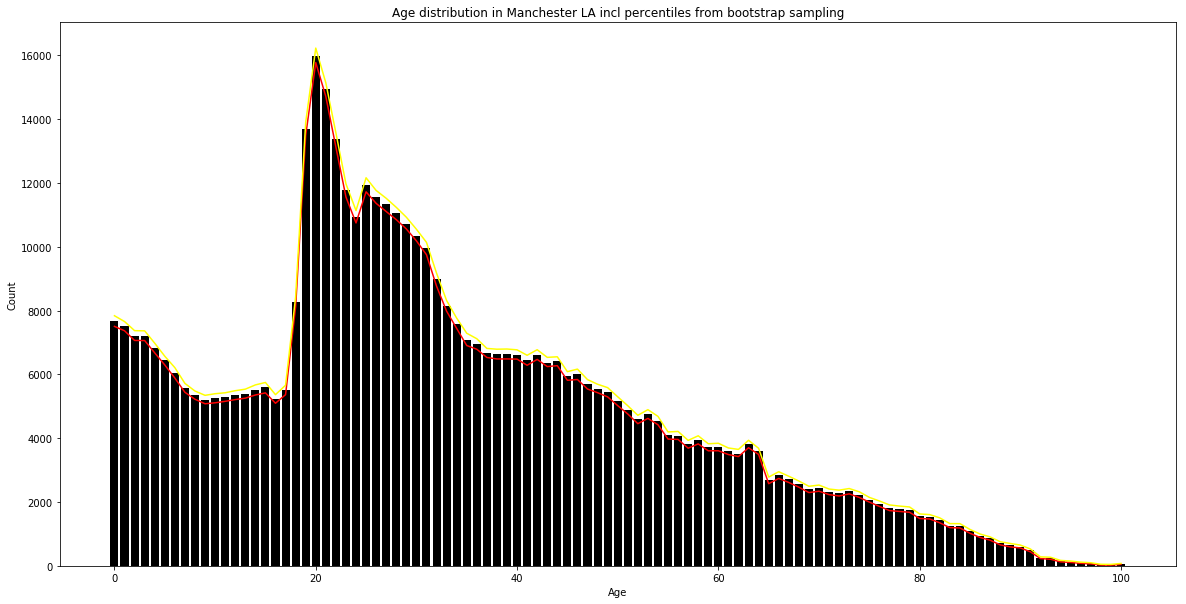

In [7]:
#Plot the percentiles, median and/or the main data
figure(figsize=(20,10))                             #increase size of plot
#plt.plot(age_counts, color = 'green')              #plotting original data
plt.bar(np.arange(0,101),age_counts,color=[0, 0, 0])#plotting original data with barchart instead
plt.plot(bootstrap_lower, color ='red')             #plot lower percentile for the bootstrap samples
plt.plot(bootstrap_upper, color = 'yellow')         #plot upper percentile for the bootstrap samples
#plt.plot(bootstrap_median, color = 'blue')         #plot median for the bootstrap samples
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in Manchester LA incl percentiles from bootstrap sampling')
plt.show()

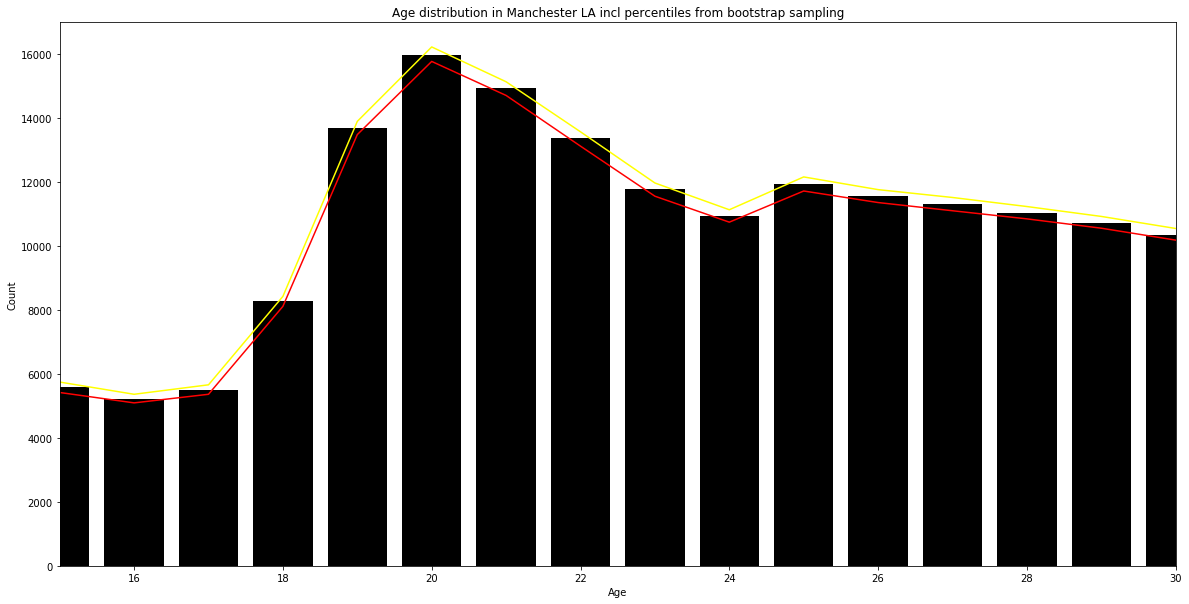

In [8]:
#Plot the percentiles, median and/or the main data while zooming in on 15<x<30
figure(figsize=(20,10))                                                     
plt.axis([15,30,0,17000])                                                  
#plt.plot(age_counts, color = 'green')                                      
plt.bar(np.arange(0,101),age_counts,color=[0, 0, 0])                       
plt.plot(bootstrap_lower, color ='red')                                     
plt.plot(bootstrap_upper, color = 'yellow')                                 
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in Manchester LA incl percentiles from bootstrap sampling')
plt.show()

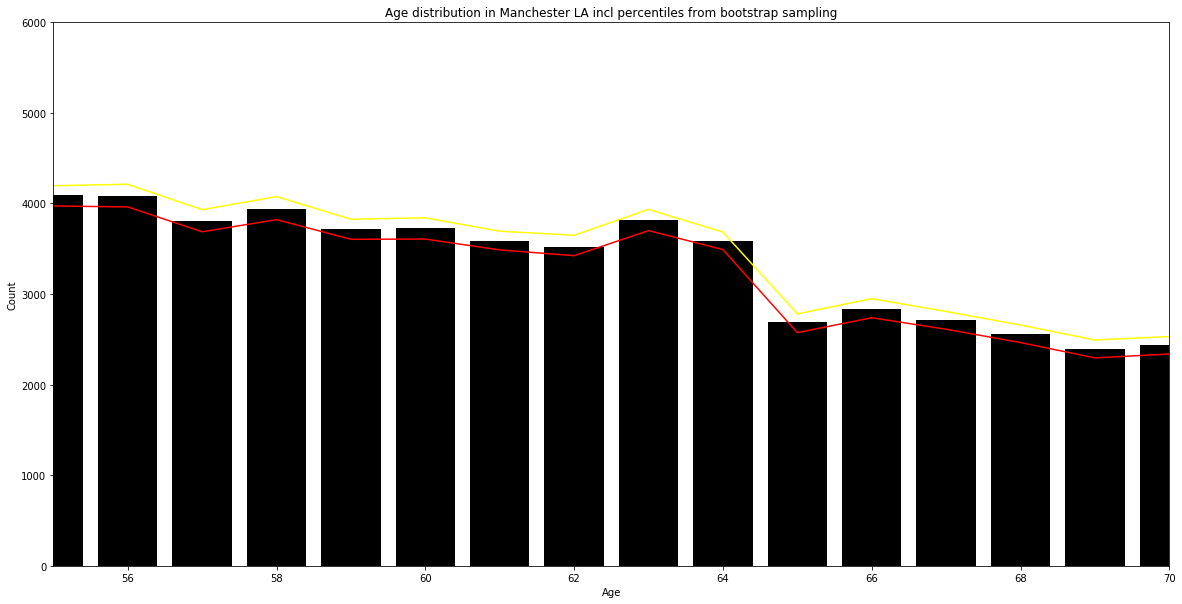

In [9]:
#Plot the percentiles, median and/or the main data while zooming in on 55<x<70
figure(figsize=(20,10))                                                     
plt.axis([55,70,0,6000])                                                  
#plt.plot(age_counts, color = 'green')                                      
plt.bar(np.arange(0,101),age_counts,color=[0, 0, 0])                       
plt.plot(bootstrap_lower, color ='red')                                     
plt.plot(bootstrap_upper, color = 'yellow')                                 
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in Manchester LA incl percentiles from bootstrap sampling')
plt.show()

In [ ]:
#checked to be sure that the original data was never outside the percentiles
for n in range(0,possible_ages):
    if age_counts[n] < bootstrap_lower[n]:
        print("At " ,str(n), " its below")
    elif age_counts[n] > bootstrap_upper[n]:
        print("At " ,str(n), " its above")
    else :
        print( str(bootstrap_lower[n]) , "<" , str(age_counts[n]) , "<" , str(bootstrap_upper[n]))


Which "wiggles" are real - based on the analysis above?
-------------------------------------------------------
By the help of the plots above I wanted to inspect the wiggles in our dataset, checking if we could say something about whether they are "real" or not (i.e. whether the number of people at a certain age is representative for the underlying population or whether it is a skew in our sample). I have plotted the original dataset (age_counts) to see whether they were very close, or potentially outside, the boundaries of the 95% confidence interval calculated from our bootstrap samples. However, the plots (and the safety check just above here) show that this is not the case, they are never outside. Thus, this does not help me much to evaluate the wiggles. One could however argue that sudden "drops"/"bumps" in the amount of people at a certain age, if we look at the original data, seems like a potential "unreal" wiggle. For instance, if we look at the number of people at age 24 vs 23/25 - we can se such a drop. The same is the case for 65 vs 64/66. Unless we can find an incident or explanation which tells us why there is a lot less people of these particular ages, we can argue that these might be wiggles which are not actually present in the underying population.

--------------------------------------------------------------------------                                               

Discussion of alternative algorithmic approaches to bootstrapping and their efficiency.
--------------------------------------------------------------------------------------
In my code above I have shown two different ways to populate my boostrap samples, one using np.random.randint (strategy 1) and one using np.random.multinominal (strategy 2). When I first tried using the np.random.randint function it took a long time to just create a small number of bootstrap samples. As we needed a lot more (in this hand-in I have used 200 bootstrap samples) I looked for other functions in python. One alternative would have been to try np.random.choices, which randomly chooses a specified number of elements from a list with replacement - which is exactly what we wanted for the bootstrap samples. However, some online googling showed that this function is also rather slow - which is inconvenient when you want many samples. Therefore, I ended up using np.random.multinominal instead, which helps me create 200 boostrap samples in less than a second.